# Trying to make a nice video of a cascade plume 



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndi
from random import random
import matplotlib
from netCDF4 import Dataset
import matplotlib.cm as cm
import matplotlib.pyplot as plt    # The code below assumes this convenient renaming
import math
import seaborn as sns
sns.set()
import time
import sys 
import pandas as pd

from binomial_function_collection import *

## Time stepping

In [90]:
def func_timestepping_smokestack(iadv):
    """
    Should have objects originating in one cell, and cascade while being advected
    
    """

    #--- time loop ----
    for t in range(ntim):


        t0 = time.time()
        

        #--- Energy cascade: decay of oldest objects in demographic record ---
        B_cas[:,:,:] = 0.
        if cascade_flag:
            for l in range(nsiz-1,0,-1):
                B_cas[:,:,l-1] = 2 * N[:,:,l,t-1,nage-1]   #split em in two, insert as birth of smaller objects
                #print("t=%s  l:%s  max B_cas:%s" % (t, l, np.max(B_cas[:,:,l])) )

                
        #--- species loop ---
        for l in range(nsiz):

            
            for i in range(nage-1,0,-1):

                #--- Object birthdays! Time-shift of the demographics levels ---
                #print("t=%s  l:%s  i:%s  max N:%s" % (t, l, i, np.max(N[:,:,l,t-1,i])) )
                N[:,:,l,t,i] = N[:,:,l,t-1,i-1]   #note: oldest level is forgotten

            
                #---Apply advection operator, after demographic shift ---
                if (iadv==1):
                    #advection for each age level separately
                    N[:,:,l,t,i] = func_advection_binomial_2D(N[:,:,l,t,i],u*dtim/dx,v*dtim/dy,periodic_flag=False)
        
            if (iadv==2):
                #1-age proxy
                dumN = func_advection_binomial_2D( np.sum(N[:,:,l,t,:],axis=2),u*dtim/dx,v*dtim/dy,periodic_flag=False)  

            


            #--- Births ---
            B = np.random.binomial(N_tot_ref[l], p[:,:,l,t].ravel(), nx*ny)
            B = B.reshape([nx,ny])
            # Warning! Need to make sure that the resizing is done correctly, so that x and y aren't swapped accidentally
            
            
            #--- Update object number: add births as level 1 demographics ---
            #N[:,:,l,t,0] = B                
            N[:,:,l,t,0] = B + B_cas[:,:,l]  # add births due to E-cascade
            
            #print( "t=%s  time = %s" % (t, t*dtim),' sizebin' ,l,'max birth: ',np.max(B),np.max(N[:,:,l,t,0]))
            
            
        t1 = time.time()

        dt_diag[iadv,t] = (t1-t0) / (nx*ny*nsiz)    #advection per age level per size species


        
    return N


# Big domain version

In [76]:
#--- Grid parameters ----------
nx   = 15     #grid size
ny   = 15

#nsiz = 1       #nr of sizes in spectrum
nsiz = 5       #nr of sizes in spectrum

#ntim = 10     #nr of timesteps
ntim = 201    #nr of timesteps  12 hours

nage = 1        #dimension of thermal demographics: number of thermal age strata

dx   = 100.    #x gridspacing     [m]
dy   = 100.     #y gridspacing     [m]
dsiz = 100.    #width of size bin [m]
dtim = 60.     #time increment    [s]


#--- Reference domain ---
L_ref    = 1000000.   #size of very large reference domain  [m]
dt_ref   = dtim       #timestep of very large ref domain    [s]


#--- birth and lifetime constants --------
B_0  = np.zeros(nsiz)    #average nr of object births / m2 / s
#B_0[nsiz-1]    = 1.e-8  
#B_0[nsiz-1]    = 1.e-9  
B_0[nsiz-1]    = 5.e-6   

tau_D     = 600.    #object life time  [s]
#tau_D     = 150.    #object life time  [s]
tau_D_dt  = int(tau_D/dtim) #object life time in timesteps []

nage = int(tau_D/dtim)   #demographics: number of object age strata


#--- pulsating growth parameters
pulse_growth_flag = 0
#pulse_growth_flag = 1
r_pulse   = 300.    #radius of impact cone of pulsating growth  [m]
fac_pulse =  40.    #factor of proportionality in impact of pulsating growth on p


#--- energy cascade mode (big objects break up into smaller ones) ---
#cascade_flag = 0
cascade_flag = 1


#--- Advection parameters
u  = 0.3  #x wind, used for advection [m/s]
v  = 0.2  #y wind, used for advection [m/s]


#--- declare arrays -----------
x    = ( np.array(range(nx  )) + 0.5) * dx
y    = ( np.array(range(ny  )) + 0.5) * dy
siz  = ( np.array(range(nsiz)) + 0.5) * dsiz
tim  = ( np.array(range(ntim)) + 0.5) * dtim

N        = np.zeros( (nx,ny,nsiz,ntim,nage) ).astype(int)   #object number
p        = np.zeros( (nx,ny,nsiz,ntim) )                    #object birth probability
dp_pulse = np.empty( (nx,ny) )                     #perturbation in p due to pulsating growth (rule 1)
B_cas    = np.zeros( (nx,ny,nsiz) ).astype(int)    #births due to energy cascade



#--- binomial probability values -----------
N_tot_ref = np.zeros(nsiz)
N_tot_ref[:] = (B_0[:]*L_ref*L_ref*dt_ref).astype(int)  #total nr of objects born in reference domain
#print( N_tot_ref[0] )

prob_sub = dx*dy*dtim/(dt_ref*L_ref*L_ref)     #probability that one of N_tot_ref births happens in a gridbox
print( "prob_sub=%s" % (prob_sub) )

#p[:,:,:,:] = prob_sub    #horizontally homogeneous
p[2,2,:,:] = prob_sub    #births at a single gridpoint only (plume mode)

for i in range(len(siz)):
    print( "size=%s B0=%s N_tot_ref=%s" % (siz[i],B_0[i],N_tot_ref[i]) )

    
            
np.random.seed(1)
        
#--- time diagnostics ---   
nadv = 3
dt_diag = np.empty( (nadv,ntim) )
            

prob_sub=1e-08
size=50.0 B0=0.0 N_tot_ref=0.0
size=150.0 B0=0.0 N_tot_ref=0.0
size=250.0 B0=0.0 N_tot_ref=0.0
size=350.0 B0=0.0 N_tot_ref=0.0
size=450.0 B0=5e-06 N_tot_ref=300000000.0


In [77]:
iadv=1
N = func_timestepping_smokestack(iadv);
    

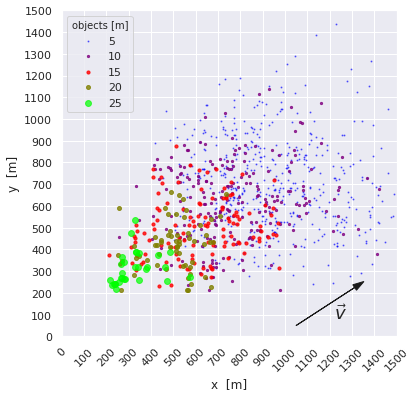

In [89]:
fig = plot_scatter_time(N,150,dx=dx,dy=dy,figsize=(6,6),color=color_rgb,sizes=[1,5,10,16,35],buffer=[0.97,0.96,0.95,0.94,0.93],alpha=[0.5,0.8,0.8,0.8,0.7],labels=['5','10','15','20','25'])

axes =plt.gca()
plt.xticks(rotation=45)
plt.legend(loc='upper left',ncol=1,title='objects [m]')
plt.title('')

axes.arrow(1050, 50, 300/8*7, 200/8*7, head_width=30, head_length=50, fc='k', ec='k')
axes.text( 1220, 80, r'$\vec{v}$',fontsize=18)
plt.show()

In [91]:
fig.savefig('fig/smoke_stack_0521_big.pdf',bbox_inches='tight')

# Settings  and initialization

In [3]:


#--- Grid parameters ----------
nx   = 20     #grid size
ny   = 10

#nsiz = 1       #nr of sizes in spectrum
nsiz = 5       #nr of sizes in spectrum

#ntim = 10     #nr of timesteps
ntim = 201    #nr of timesteps  12 hours

nage = 1        #dimension of thermal demographics: number of thermal age strata

dx   = 100.    #x gridspacing     [m]
dy   = 100.     #y gridspacing     [m]
dsiz = 100.    #width of size bin [m]
dtim = 60.     #time increment    [s]


#--- Reference domain ---
L_ref    = 1000000.   #size of very large reference domain  [m]
dt_ref   = dtim       #timestep of very large ref domain    [s]


#--- birth and lifetime constants --------
B_0  = np.zeros(nsiz)    #average nr of object births / m2 / s
#B_0[nsiz-1]    = 1.e-8  
#B_0[nsiz-1]    = 1.e-9  
B_0[nsiz-1]    = 5.e-6   

tau_D     = 600.    #object life time  [s]
#tau_D     = 150.    #object life time  [s]
tau_D_dt  = int(tau_D/dtim) #object life time in timesteps []

nage = int(tau_D/dtim)   #demographics: number of object age strata


#--- pulsating growth parameters
pulse_growth_flag = 0
#pulse_growth_flag = 1
r_pulse   = 300.    #radius of impact cone of pulsating growth  [m]
fac_pulse =  40.    #factor of proportionality in impact of pulsating growth on p


#--- energy cascade mode (big objects break up into smaller ones) ---
#cascade_flag = 0
cascade_flag = 1


#--- Advection parameters
u  = 0.4  #x wind, used for advection [m/s]
v  = 0.1  #y wind, used for advection [m/s]


#--- declare arrays -----------
x    = ( np.array(range(nx  )) + 0.5) * dx
y    = ( np.array(range(ny  )) + 0.5) * dy
siz  = ( np.array(range(nsiz)) + 0.5) * dsiz
tim  = ( np.array(range(ntim)) + 0.5) * dtim

N        = np.zeros( (nx,ny,nsiz,ntim,nage) ).astype(int)   #object number
p        = np.zeros( (nx,ny,nsiz,ntim) )                    #object birth probability
dp_pulse = np.empty( (nx,ny) )                     #perturbation in p due to pulsating growth (rule 1)
B_cas    = np.zeros( (nx,ny,nsiz) ).astype(int)    #births due to energy cascade



#--- binomial probability values -----------
N_tot_ref = np.zeros(nsiz)
N_tot_ref[:] = (B_0[:]*L_ref*L_ref*dt_ref).astype(int)  #total nr of objects born in reference domain
#print( N_tot_ref[0] )

prob_sub = dx*dy*dtim/(dt_ref*L_ref*L_ref)     #probability that one of N_tot_ref births happens in a gridbox
print( "prob_sub=%s" % (prob_sub) )

#p[:,:,:,:] = prob_sub    #horizontally homogeneous
p[1,1,:,:] = prob_sub    #births at a single gridpoint only (plume mode)

for i in range(len(siz)):
    print( "size=%s B0=%s N_tot_ref=%s" % (siz[i],B_0[i],N_tot_ref[i]) )

    
            
np.random.seed(1)
        
#--- time diagnostics ---   
nadv = 3
dt_diag = np.empty( (nadv,ntim) )
            

prob_sub=1e-08
size=50.0 B0=0.0 N_tot_ref=0.0
size=150.0 B0=0.0 N_tot_ref=0.0
size=250.0 B0=0.0 N_tot_ref=0.0
size=350.0 B0=0.0 N_tot_ref=0.0
size=450.0 B0=5e-06 N_tot_ref=300000000.0


In [55]:
# New more "plumy" version

#--- Grid parameters ----------
nx   = 20     #grid size
ny   = 10

#nsiz = 1       #nr of sizes in spectrum
nsiz = 5       #nr of sizes in spectrum

#ntim = 10     #nr of timesteps
ntim = 201    #nr of timesteps  12 hours

nage = 1        #dimension of thermal demographics: number of thermal age strata

dx   = 100.    #x gridspacing     [m]
dy   = 100.     #y gridspacing     [m]
dsiz = 100.    #width of size bin [m]
dtim = 60.     #time increment    [s]


#--- Reference domain ---
L_ref    = 1000000.   #size of very large reference domain  [m]
dt_ref   = dtim       #timestep of very large ref domain    [s]


#--- birth and lifetime constants --------
B_0  = np.zeros(nsiz)    #average nr of object births / m2 / s
#B_0[nsiz-1]    = 1.e-8  
#B_0[nsiz-1]    = 1.e-9  
B_0[nsiz-1]    = 5.e-6   

tau_D     = 600.    #object life time  [s]
#tau_D     = 150.    #object life time  [s]
tau_D_dt  = int(tau_D/dtim) #object life time in timesteps []

nage = int(tau_D/dtim)   #demographics: number of object age strata


#--- pulsating growth parameters
pulse_growth_flag = 0
#pulse_growth_flag = 1
r_pulse   = 300.    #radius of impact cone of pulsating growth  [m]
fac_pulse =  40.    #factor of proportionality in impact of pulsating growth on p


#--- energy cascade mode (big objects break up into smaller ones) ---
#cascade_flag = 0
cascade_flag = 1


#--- Advection parameters
u  = 0.3  #x wind, used for advection [m/s]
v  = 0.15  #y wind, used for advection [m/s]


#--- declare arrays -----------
x    = ( np.array(range(nx  )) + 0.5) * dx
y    = ( np.array(range(ny  )) + 0.5) * dy
siz  = ( np.array(range(nsiz)) + 0.5) * dsiz
tim  = ( np.array(range(ntim)) + 0.5) * dtim

N        = np.zeros( (nx,ny,nsiz,ntim,nage) ).astype(int)   #object number
p        = np.zeros( (nx,ny,nsiz,ntim) )                    #object birth probability
dp_pulse = np.empty( (nx,ny) )                     #perturbation in p due to pulsating growth (rule 1)
B_cas    = np.zeros( (nx,ny,nsiz) ).astype(int)    #births due to energy cascade



#--- binomial probability values -----------
N_tot_ref = np.zeros(nsiz)
N_tot_ref[:] = (B_0[:]*L_ref*L_ref*dt_ref).astype(int)  #total nr of objects born in reference domain
#print( N_tot_ref[0] )

prob_sub = dx*dy*dtim/(dt_ref*L_ref*L_ref)     #probability that one of N_tot_ref births happens in a gridbox
print( "prob_sub=%s" % (prob_sub) )

#p[:,:,:,:] = prob_sub    #horizontally homogeneous
p[2,1,:,:] = prob_sub    #births at a single gridpoint only (plume mode)

for i in range(len(siz)):
    print( "size=%s B0=%s N_tot_ref=%s" % (siz[i],B_0[i],N_tot_ref[i]) )

    
            
np.random.seed(1)
        
#--- time diagnostics ---   
nadv = 3
dt_diag = np.empty( (nadv,ntim) )
            

prob_sub=1e-08
size=50.0 B0=0.0 N_tot_ref=0.0
size=150.0 B0=0.0 N_tot_ref=0.0
size=250.0 B0=0.0 N_tot_ref=0.0
size=350.0 B0=0.0 N_tot_ref=0.0
size=450.0 B0=5e-06 N_tot_ref=300000000.0


# Now the fun starts!

In [56]:
iadv=1
N = func_timestepping_smokestack(iadv);
    

# Plotting

In [57]:
# 70s colorbar :)
from matplotlib import cm
cmap = cm.get_cmap('cool_r',10)
cmap = cm.get_cmap('brg',5)
color_rgb = [None]*5
#cmap = func_generate_random_cmap(N_color=10)
for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    color_rgb[i] = matplotlib.colors.rgb2hex(rgb)

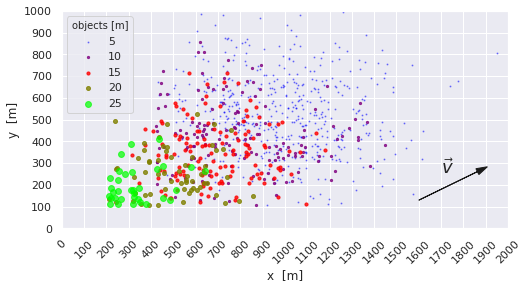

In [73]:
#fig = plot_scatter_time(N,140,dx=dx,dy=dy,figsize=(10,5),color=color_rgb,sizes=[1,5,10,16,32],buffer=[0.875,0.85,0.825,0.8,0.75],alpha=[1.0,0.8,0.8,0.8,0.8],labels=['1','2','3','4','5'])
#fig = plot_scatter_time(N,140,dx=dx,dy=dy,figsize=(10,4),color=color_rgb,sizes=[1,5,10,16,35],buffer=[0.9,0.875,0.85,0.825,0.775],alpha=[1.0,0.8,0.8,0.8,0.7],labels=['1','2','4','8','16'])
#fig = plot_scatter_time(N,160,dx=dx,dy=dy,figsize=(4,8),color=color_rgb,sizes=[1,5,10,16,35],buffer=[0.97,0.96,0.95,0.94,0.93],alpha=[0.4,0.8,0.8,0.8,0.7],labels=['5','10','15','20','25'])
fig = plot_scatter_time(N,140,dx=dx,dy=dy,figsize=(8,4),color=color_rgb,sizes=[1,5,10,16,35],buffer=[0.97,0.96,0.95,0.94,0.93],alpha=[0.4,0.8,0.8,0.8,0.7],labels=['5','10','15','20','25'])

axes =plt.gca()
plt.xticks(rotation=45)
plt.legend(loc='upper left',ncol=1,title='objects [m]')
plt.title('')

axes.arrow(1600, 130, 300/8*7, 150/8*7, head_width=30, head_length=50, fc='k', ec='k')
axes.text(1700, 250, r'$\vec{v}$',fontsize=18)
plt.show()

In [75]:
fig.savefig('fig/smoke_stack_0521.pdf',bbox_inches='tight')

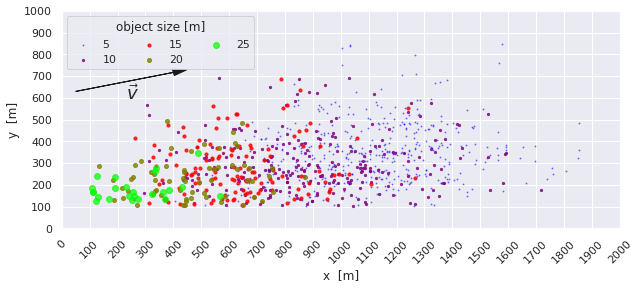

In [23]:
#fig = plot_scatter_time(N,140,dx=dx,dy=dy,figsize=(10,5),color=color_rgb,sizes=[1,5,10,16,32],buffer=[0.875,0.85,0.825,0.8,0.75],alpha=[1.0,0.8,0.8,0.8,0.8],labels=['1','2','3','4','5'])
#fig = plot_scatter_time(N,140,dx=dx,dy=dy,figsize=(10,4),color=color_rgb,sizes=[1,5,10,16,35],buffer=[0.9,0.875,0.85,0.825,0.775],alpha=[1.0,0.8,0.8,0.8,0.7],labels=['1','2','4','8','16'])
#fig = plot_scatter_time(N,160,dx=dx,dy=dy,figsize=(10,4),sizes=[1,5,10,16,35],buffer=[0.97,0.96,0.95,0.94,0.93],alpha=[1.0,0.8,0.8,0.8,0.7],labels=['5','10','15','20','25'],color = ['k','b','orange','r','g'])

#fig = plot_scatter_time(N,160,dx=dx,dy=dy,figsize=(10,4),sizes=[1,5,10,16,35],buffer=[0.97,0.96,0.95,0.94,0.93],alpha=[1.0,0.8,0.8,0.8,0.7],labels=['5','10','15','20','25'],color = ['k','b','orange','r','g'])
fig = plot_scatter_time(N,160,dx=dx,dy=dy,figsize=(10,4),color=color_rgb,sizes=[1,5,10,16,35],buffer=[0.97,0.96,0.95,0.94,0.93],alpha=[0.4,0.8,0.8,0.8,0.7],labels=['5','10','15','20','25'])
axes =plt.gca()
plt.xticks(rotation=45)
plt.legend(loc='upper left',ncol=3,title='object size [m]')
plt.title('')

axes.arrow(50, 630, 400/8*7, 100/8*7, head_width=30, head_length=50, fc='k', ec='k')
axes.text(230, 590, r'$\vec{v}$',fontsize=18)
plt.show()

In [24]:
fig.savefig('fig/smoke_stack_0520_small_alt.pdf',bbox_inches='tight')

In [25]:
#Working on making a nicer video with slower movement in the individual cells
plot_scatter_movie(N,0,200,name='smoke',dx=dx,dy=dy,figsize=(10,4),color=color_rgb,sizes=[1,5,10,16,35],buffer=[0.97,0.96,0.95,0.94,0.93],alpha=[0.4,0.8,0.8,0.8,0.7],rotation=45)


saved: mov/N_movie_smoke_dt000.png
saved: mov/N_movie_smoke_dt001.png
saved: mov/N_movie_smoke_dt002.png
saved: mov/N_movie_smoke_dt003.png
saved: mov/N_movie_smoke_dt004.png
saved: mov/N_movie_smoke_dt005.png
saved: mov/N_movie_smoke_dt006.png
saved: mov/N_movie_smoke_dt007.png
saved: mov/N_movie_smoke_dt008.png
saved: mov/N_movie_smoke_dt009.png
saved: mov/N_movie_smoke_dt010.png
saved: mov/N_movie_smoke_dt011.png
saved: mov/N_movie_smoke_dt012.png
saved: mov/N_movie_smoke_dt013.png
saved: mov/N_movie_smoke_dt014.png
saved: mov/N_movie_smoke_dt015.png
saved: mov/N_movie_smoke_dt016.png
saved: mov/N_movie_smoke_dt017.png
saved: mov/N_movie_smoke_dt018.png
saved: mov/N_movie_smoke_dt019.png
saved: mov/N_movie_smoke_dt020.png
saved: mov/N_movie_smoke_dt021.png
saved: mov/N_movie_smoke_dt022.png
saved: mov/N_movie_smoke_dt023.png
saved: mov/N_movie_smoke_dt024.png
saved: mov/N_movie_smoke_dt025.png
saved: mov/N_movie_smoke_dt026.png
saved: mov/N_movie_smoke_dt027.png
saved: mov/N_movie_s

# Now to add the distribution plot

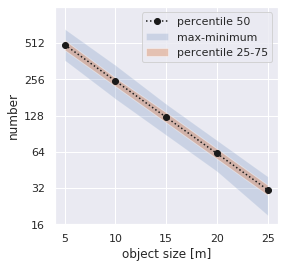

In [13]:
#get all ages together
N_over_age = np.sum(N,axis=4)
N_over_x = np.sum(N_over_age,axis=0)
N_over_y = np.sum(N_over_x,axis=0)
N_over_t = np.sum(N_over_y,axis=0)

#--- percentile plot of the CSD ---
fig,ax = plt.subplots(1,1,figsize=(4,4))


#overwriting siz
siz = np.array([1,2,4,8,16])
siz = np.array([5,10,15,20,25])

sd_N_lin_p01    = np.percentile( N_over_y[:,100:],  1., axis=1 ,interpolation='nearest')    #25% percentile
sd_N_lin_p25    = np.percentile( N_over_y[:,100:], 25., axis=1 ,interpolation='nearest')    #25% percentile
sd_N_lin_p50    = np.percentile( N_over_y[:,100:], 50., axis=1 ,interpolation='nearest')    #50% percentile
sd_N_lin_p75    = np.percentile( N_over_y[:,100:], 75., axis=1 ,interpolation='nearest')    #75% percentile
sd_N_lin_p99    = np.percentile( N_over_y[:,100:], 99., axis=1 ,interpolation='nearest')    #75% percentile
sd_N_lin_max    = np.max( N_over_y[:,100:], axis=1)    #75% percentile
sd_N_lin_min    = np.min( N_over_y[:,100:], axis=1)    #75% percentile



#plt.fill_between(siz, sd_N_lin_p01, sd_N_lin_p99, alpha=0.2,label='percentile 01-99')
plt.fill_between(siz, sd_N_lin_min, sd_N_lin_max, alpha=0.2,label='max-minimum')
plt.fill_between(siz, sd_N_lin_p25, sd_N_lin_p75, alpha=0.4,label='percentile 25-75')
plt.plot        (siz, sd_N_lin_p50, 'o:', color='k'        ,label='percentile 50')


plt.legend()





plt.xlabel('object size [m]')
plt.ylabel('number')

plt.ylim([16,4**5])
#plt.xlim([40,1100.])
#plt.xscale('log')
plt.yscale('log')
ax.set_xticks(siz[[0,1,2,3,4]])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax.set_yticks([int(16),2**5,4**3,2**7,4**4,2**9])

ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

    
#plt.show()                         # Show the figure

#fig.savefig('N_thermals_movie_CSD.png',bbox_inches = 'tight')
#fig.savefig('N_thermals_movie_CSD.pdf',bbox_inches = 'tight')

#plt.close(fig)



In [14]:
fig.savefig('fig/smoke_stack_distribution_0520.pdf',bbox_inches='tight')